In [17]:
import torch
import numpy as np
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from os.path import join
from sklearn.metrics import accuracy_score


# Multilayer Perceptron (MLP)

Modelli lineari per classificazione e regressione possono essere estesi in maniera più semplice a modelli più "profondi", quali multiLayer Perceptron (MLP) mediante pytorch.
Una rete di tipo MLP è composta da tre livelli:
- livello di "input" nel quale verranno presentati i dati in ingresso
- livello "nascosto" che conterrà la rappresentazione "latenti" dei dati. detto tale dato che durante il training non viene esercitato un controllo diretto sui valori che esso assume (loss applicata al layer di output). Il livello apprende da una rappresentazione latente
- livello di "uscita" che conterrà i dati di output (le etichette regresse)

Dei tre, gli unici due che possono essere appresi sono il secondo e il terzo. Per questo si dice spesso che un MLP contiene solo due "layer".

Nel caso dell'implementazione di un regressore l'ultimo livello del MLP conterrebbe i valori da regredire. Nel caso in cui volessimo implementare un regressore softmax(classificatore), l'ultimo livello deve contenere un numero di nodi pari al numero di classi e i valori assunti da questi nodi sono da considerarsi dei logit.

## Fashionist-mnist

Dataset relativo alla moda con:
- 60.000 immagini di training
- 10.000 immagini di testing grandi 28x28 pixels
- 10 classi

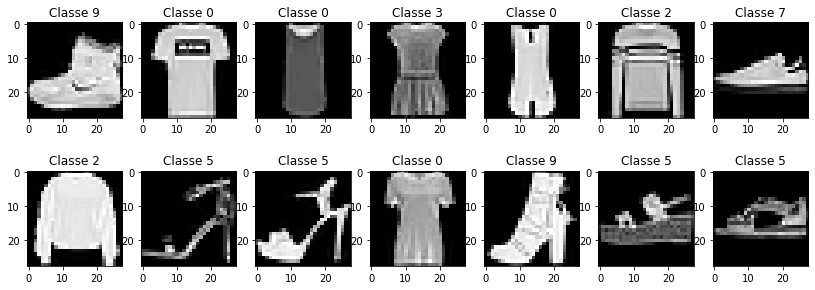

In [2]:
fashion_train = FashionMNIST(root='fashion',train=True, download=True, transform=transforms.ToTensor())
fashion_test = FashionMNIST(root='fashion',train=False, download=True, transform=transforms.ToTensor())
plt.figure(figsize=(14,5)) 

for i in range(14):
    plt.subplot(2,7,i+1)
    plt.title("Classe %d" % fashion_train[i][1])
    plt.imshow(fashion_train[i][0].squeeze().numpy(),cmap='gray')
#`squeeze` serve a trasformare il tensore 1 x 28 x 28 in un tensore 28 x 28
plt.show()

Definiamo i dataloaders con le opportune trasformazioni. Utilizzeremo la media e deviazione standard relative al dataset (sono state pre-computate):

In [3]:
media = 0.2860
dev_std = 0.3530

transform = transforms.Compose([transforms.ToTensor(), #conversione in tensore 
                                transforms.Normalize((media,),(dev_std,)),  # normalizzazione per media e dv std del dataset
                                torch.flatten ])   # trasformo l'immagine 28x28 in un vettore di 784 componenti
# ridefinisco i dataset specificando le trasformazioni
fashion_train = FashionMNIST(root='data',train=True, download=True, transform=transform)
fashion_test = FashionMNIST(root='data',train=False, download=True, transform=transform)
# definisco i data loaders
fashion_train_loader = DataLoader(fashion_train, batch_size=256, num_workers=2, shuffle=True)   # shuffle --> accede ai dati in maniera casuale
fashion_test_loader = DataLoader(fashion_test, batch_size=256, num_workers=2)

## Funzioni scritte precedentemente

In [4]:
class SoftMaxRegressor(nn.Module):
    def __init__(self, in_features, out_classes):
        """Costruisce un regressore softmax
            Input:
                in_features: numero di feature in input (es.4)
                out_classes: numero di classi in uscita (es.3) """
        super(SoftMaxRegressor, self).__init__()    ## richiamo costruttore della superclasse, passo necessario per abilitare alcuni meccanismi automatici di PyTorch

        self.linear = nn.Linear(in_features, out_classes)   ## il regressore softmax restituisce distr di probabilità, quindi il numero di feature di output coincide con il numero di classi. è lineare in quanto il softmax viene implementato nella loss

    def forward(self,x):
        """Definisce come processare l'input x"""
        scores = self.linear(x)
        return scores

In [5]:
class AverageValueMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.num = 0

    def add(self, value, num):
        self.sum += value*num
        self.num += num

    def value(self):
        try:
            return self.sum/self.num
        except:
            return None

In [6]:
def train_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.001, epochs=10, momentum=0.9, logdir='logs'):

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum)

    # meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    # writer
    writer = SummaryWriter(join(logdir, exp_name))
    # device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    ## definiamo un dizionario contenente i loader di training e test
    loader = {
        'train': train_loader,
        'test': test_loader
    }
    global_step = 0
    for e in range(epochs):
        # iteriamo tra due modalità: train e test
        for mode in ['train', 'test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): # abilitiamo i gradienti o solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) # portiamoli su device corretto
                    y=batch[1].to(device)
                    output = model(x)

                    # aggiorniamo il global_step
                    # conterrà il numero di campioni visti durante il training
                    n = x.shape[0]  # n di elementi nel batch
                    global_step += n
                    l = criterion(output, y)

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    acc = accuracy_score(y.to('cpu'), output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(), n)
                    acc_meter.add(acc,n)

                    # loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode == 'train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                        # una volta finita l'epoca sia nel caso di training che di test loggiamo le stime finali

                writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
                writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)

                        ## conserviamo i pesi del modello alla fine di un ciclo di training e test

        torch.save(model.state_dict(), '%s-%d.pth'%(exp_name, e+1))
    return model

In [15]:
def test_classifier(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    predictions, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        output = model(x)
        preds = output.to('cpu').max(1)[1].numpy()
        labs = y.to('cpu').numpy()
        predictions.extend(list(preds))
        labels.extend(list(labs))
    
    return np.array(predictions), np.array(labels)

Esploro il dataset allenando un regressore softmax:

In [8]:
fashion_softmax_regressor = SoftMaxRegressor(784, 10)
fashion_softmax_regressor = train_classifier(fashion_softmax_regressor, fashion_train_loader, fashion_test_loader, 'files/fashion_softmax_regressor', lr=0.01, epochs = 10)

Otteniamo accuracy di training e test

In [18]:
predictions_train_fashion_softmax_regressor, labels_train_fashion = test_classifier(fashion_softmax_regressor, fashion_train_loader)
predictions_test_fashion_softmax_regressor, labels_test_fashion = test_classifier(fashion_softmax_regressor, fashion_test_loader)

print("Fashion Softmax Regressor - Accuarcy di training: %0.4f"% accuracy_score(labels_train_fashion, predictions_train_fashion_softmax_regressor))
print("Fashion Softmax Regressor - Accuarcy di test: %0.4f"% accuracy_score(labels_test_fashion, predictions_test_fashion_softmax_regressor))

Fashion Softmax Regressor - Accuarcy di training: 0.8659
Fashion Softmax Regressor - Accuarcy di test: 0.8433


## Classificatore MLP
Vediamo come implementare un semplice classificatore MLP. Utilizzeremo la tangente iperbolica come funzione di attivazione:

In [21]:
class MLPClassifier(nn.Module):
    def __init__(self, in_features, hidden_units, out_classes):
        """Costruisce un classificatore MLP. Input:
            in_features: numero di feature in input (es. 784) hidden_units: numero di unità nel livello nascosto (es. 512 out_classes: numero di classi in uscita (es. 10)"""
        super(MLPClassifier, self).__init__()
        self.hidden_layer = nn.Linear(in_features, hidden_units)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(hidden_units, out_classes)

    def forward(self,x):
        hidden_representation = self.hidden_layer(x)
        hidden_representation = self.activation(hidden_representation)
        scores = self.output_layer(hidden_representation)
        return scores
 

Alleniamo il cassificatore MLP su fashion-MNIST


In [23]:
fashion_mlp_classifier = MLPClassifier(784, 512, 10)
fashion_mlp_classifier = train_classifier(fashion_mlp_classifier, fashion_train_loader, fashion_test_loader, 'files/fashion_mlp_classifier', lr=0.01, epochs=10)

Calcoliamo accuracy di training e test

In [24]:
predictions_train_fashion_mlp_classifier, labels_train = test_classifier(fashion_mlp_classifier, fashion_train_loader)
predictions_test_fashion_mlp_classifier, labels_test = test_classifier(fashion_mlp_classifier, fashion_test_loader)

print("Fashion MLP Classifier - Accuarcy di training: %0.4f"% accuracy_score(labels_train, predictions_train_fashion_mlp_classifier))
print("Fashion MLP Classifier - Accuarcy di test: %0.4f"% accuracy_score(labels_test, predictions_test_fashion_mlp_classifier))

Fashion MLP Classifier - Accuarcy di training: 0.8982
Fashion MLP Classifier - Accuarcy di test: 0.8712


## Classificatore MLP profondo